# Analisis dólar oficial vs dólar blue


## Preparacion de la informacion y los DataFrames

In [ ]:
# Importo las librerías que voy a usar a lo largo del analisis
import requests
import datetime as dt
import seaborn as sns
import json
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Creo una funcion para traer de la API los json como dataframes
def url_to_df(url):
  response = requests.get(url, headers={'Authorization': 'TOKEN'})
  df = pd.DataFrame(response.json())
  return df

In [ ]:
# Creo los dataframes que voy a usar para este analisis 
# (dolar blue, oficial y sucesos que pueden haber impactado el valor del dolar)
dolar = url_to_df('https://api.estadisticasbcra.com/usd')
dolar_of = url_to_df('https://api.estadisticasbcra.com/usd_of')
sucesos = url_to_df('https://api.estadisticasbcra.com/milestones')

In [ ]:
# Uno los dataframes del dolar blue y oficial por fecha para comparar
of_vs_blue_full = dolar_of.merge(dolar, on='d')
of_vs_blue_full

,d,v_x,v_y
0,2002-03-04,2.01,2.12
1,2002-03-05,1.99,2.12
2,2002-03-06,2.05,2.14
3,2002-03-07,2.14,2.22
4,2002-03-08,2.20,2.27
...,...,...,...
5005,2022-07-29,131.23,296.00
5006,2022-08-01,131.94,282.00
5007,2022-08-02,132.18,291.00
5008,2022-08-03,132.41,298.00


In [ ]:
# Renombro las columnas para referirlas mas comodamente
of_vs_blue_full = of_vs_blue_full.rename(columns={'d':'date', 'v_x' : 'dolar_of', 'v_y' : 'dolar'})
# Preparo el dataframe para la regresion que se hace mas adelante
of_vs_blue_reg = of_vs_blue_full

In [ ]:
# Paso la columa 'date' a formato fecha para procesar la informacion
of_vs_blue_full['date'] = pd.to_datetime(of_vs_blue_full['date'])
# Reduzco el dataframe a los ultimos 365 días
of_vs_blue = of_vs_blue_full.loc[(of_vs_blue_full['date'] > of_vs_blue_full['date'].max() - pd.Timedelta(365, "d")) & (of_vs_blue_full['date'] <= of_vs_blue_full['date'].max())].reset_index()
of_vs_blue.drop('index', axis=1, inplace=True)
of_vs_blue_graf = of_vs_blue

## Día con mayor variación en la brecha

In [ ]:
# Se crea la columna con la diferencia entre el dólar oficial y el dólar blue
of_vs_blue['dif_dolar'] = of_vs_blue['dolar']-of_vs_blue['dolar_of']
of_vs_blue

,date,dolar_of,dolar,dif_dolar
0,2021-08-05,96.88,180.5,83.62
1,2021-08-06,96.91,178.5,81.59
2,2021-08-09,97.00,179.0,82.00
3,2021-08-10,97.03,178.0,80.97
4,2021-08-11,97.05,178.0,80.95
...,...,...,...,...
240,2022-07-29,131.23,296.0,164.77
241,2022-08-01,131.94,282.0,150.06
242,2022-08-02,132.18,291.0,158.82
243,2022-08-03,132.41,298.0,165.59


In [ ]:
# Creo funcion para crear las listas con la variacion del dolar dia a dia
def lista_de_variacion(columna):
  var_diaria = []
  prev_i = of_vs_blue[columna][0]
  for i in of_vs_blue[columna]:
    var_diaria.append(i-prev_i)
    prev_i = i
  return var_diaria

In [ ]:
# Creo la columna con los valores de la variacion que hubo con respecto al dia anterior en la brecha
of_vs_blue['var_brecha'] = lista_de_variacion('dif_dolar')
of_vs_blue

,date,dolar_of,dolar,dif_dolar,var_brecha
0,2021-08-05,96.88,180.5,83.62,0.00
1,2021-08-06,96.91,178.5,81.59,-2.03
2,2021-08-09,97.00,179.0,82.00,0.41
3,2021-08-10,97.03,178.0,80.97,-1.03
4,2021-08-11,97.05,178.0,80.95,-0.02
...,...,...,...,...,...
240,2022-07-29,131.23,296.0,164.77,-18.10
241,2022-08-01,131.94,282.0,150.06,-14.71
242,2022-08-02,132.18,291.0,158.82,8.76
243,2022-08-03,132.41,298.0,165.59,6.77


In [ ]:
# Uso el maximo y el minimo valor de variación de la brecha para llamar las filas del dataframe y comparar el mayor aumento con la mayor disminución.
max = of_vs_blue.loc[of_vs_blue['var_brecha'] == of_vs_blue['var_brecha'].max()]
min = of_vs_blue.loc[of_vs_blue['var_brecha'] == of_vs_blue['var_brecha'].min()]
max, min

(          date  dolar_of  dolar  dif_dolar  var_brecha
 221 2022-07-04    125.99  260.0     134.01       20.42,
           date  dolar_of  dolar  dif_dolar  var_brecha
 240 2022-07-29    131.23  296.0     164.77       -18.1)

## Top 5 dias con mayor variación

### Preparacion para ver los top 5 dias de variación

In [ ]:
# Creo una funcion para agregar una lista que contenga el tipo de variación y convierta la lista de variaciones en valor absoluto.
def trans_tipo_var(columna):
  tipo_var = []
  for i in of_vs_blue[columna]:
    if i < 0:
      tipo_var.append('neg')
    else:
      tipo_var.append('pos')
  of_vs_blue[columna].abs()
  return tipo_var

In [ ]:
# Agrego las listas como columnas del dataframe
of_vs_blue['var_oficial'] = lista_de_variacion('dolar_of')
of_vs_blue['var_blue'] = lista_de_variacion('dolar')

of_vs_blue

,date,dolar_of,dolar,dif_dolar,var_brecha,anio,mes,dia,var_oficial,var_blue
0,2021-08-05,96.88,180.5,83.62,-0.04,2021,8,5,0.00,0.0
1,2021-08-06,96.91,178.5,81.59,-2.03,2021,8,6,0.03,-2.0
2,2021-08-09,97.00,179.0,82.00,0.41,2021,8,9,0.09,0.5
3,2021-08-10,97.03,178.0,80.97,-1.03,2021,8,10,0.03,-1.0
4,2021-08-11,97.05,178.0,80.95,-0.02,2021,8,11,0.02,0.0
...,...,...,...,...,...,...,...,...,...,...
240,2022-07-29,131.23,296.0,164.77,-18.10,2022,7,29,0.10,-18.0
241,2022-08-01,131.94,282.0,150.06,-14.71,2022,8,1,0.71,-14.0
242,2022-08-02,132.18,291.0,158.82,8.76,2022,8,2,0.24,9.0
243,2022-08-03,132.41,298.0,165.59,6.77,2022,8,3,0.23,7.0


In [ ]:
of_vs_blue['tipo_var_oficial'] = trans_tipo_var('var_oficial')
of_vs_blue['tipo_var_blue'] = trans_tipo_var('var_blue')
of_vs_blue['tipo_var_brecha'] = trans_tipo_var('var_brecha')

of_vs_blue

,date,dolar_of,dolar,dif_dolar,var_brecha,anio,mes,dia,var_oficial,var_blue,tipo_var_oficial,tipo_var_blue,tipo_var_brecha
0,2021-08-05,96.88,180.5,83.62,-0.04,2021,8,5,0.00,0.0,pos,pos,neg
1,2021-08-06,96.91,178.5,81.59,-2.03,2021,8,6,0.03,-2.0,pos,neg,neg
2,2021-08-09,97.00,179.0,82.00,0.41,2021,8,9,0.09,0.5,pos,pos,pos
3,2021-08-10,97.03,178.0,80.97,-1.03,2021,8,10,0.03,-1.0,pos,neg,neg
4,2021-08-11,97.05,178.0,80.95,-0.02,2021,8,11,0.02,0.0,pos,pos,neg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,2022-07-29,131.23,296.0,164.77,-18.10,2022,7,29,0.10,-18.0,pos,neg,neg
241,2022-08-01,131.94,282.0,150.06,-14.71,2022,8,1,0.71,-14.0,pos,neg,neg
242,2022-08-02,132.18,291.0,158.82,8.76,2022,8,2,0.24,9.0,pos,pos,pos
243,2022-08-03,132.41,298.0,165.59,6.77,2022,8,3,0.23,7.0,pos,pos,pos


### Top 5 (variación de la brecha)

In [ ]:
# Llamo los 5 valores mas altos de variación en la brecha
of_vs_blue.sort_values(by=['var_brecha'], ascending=False).head()

,date,dolar_of,dolar,dif_dolar,var_brecha,var_oficial,var_blue,tipo_var_oficial,tipo_var_blue,tipo_var_brecha
221,2022-07-04,125.99,260.0,134.01,20.42,0.58,21.0,pos,pos,pos
234,2022-07-21,129.61,337.0,207.39,19.78,0.22,20.0,pos,pos,pos
225,2022-07-08,126.78,273.0,146.22,15.79,0.21,16.0,pos,pos,pos
233,2022-07-20,129.39,317.0,187.61,15.74,0.26,16.0,pos,pos,pos
228,2022-07-13,127.79,283.0,155.21,10.78,0.22,11.0,pos,pos,pos


### Top 5 (variación de dólar oficial)

In [ ]:
# LLamo los 5 valores mas altos en la variación del dolar oficial
of_vs_blue[['date', 'dolar_of', 'var_oficial', 'tipo_var_oficial']].sort_values(by=['var_oficial'], ascending=False).head()

,date,dolar_of,var_oficial,tipo_var_oficial
212,2022-06-21,123.69,0.79,pos
170,2022-04-18,113.66,0.75,pos
241,2022-08-01,131.94,0.71,pos
231,2022-07-18,128.90,0.67,pos
236,2022-07-25,130.40,0.64,pos


### Top 5 (variación de dólar blue)

In [ ]:
# LLamo los 5 valores mas altos en la variación del dolar blue
of_vs_blue[['date', 'dolar', 'var_blue', 'tipo_var_blue']].sort_values(by=['var_blue'], ascending=False).head()

,date,dolar,var_blue,tipo_var_blue
221,2022-07-04,260.0,21.0,pos
234,2022-07-21,337.0,20.0,pos
225,2022-07-08,273.0,16.0,pos
233,2022-07-20,317.0,16.0,pos
228,2022-07-13,283.0,11.0,pos


## Día de la semana con mayor variación en la brecha

In [ ]:
# Agrego columna con dia de la semana codificado por números (0 = lunes)
of_vs_blue['day_of_week'] = of_vs_blue['date'].dt.dayofweek
of_vs_blue.head()

,date,dolar_of,dolar,dif_dolar,var_brecha,anio,mes,dia,var_oficial,var_blue,tipo_var_oficial,tipo_var_blue,tipo_var_brecha,day_of_week
0,2021-08-05,96.88,180.5,83.62,-0.04,2021,8,5,0.00,0.0,pos,pos,neg,3
1,2021-08-06,96.91,178.5,81.59,-2.03,2021,8,6,0.03,-2.0,pos,neg,neg,4
2,2021-08-09,97.00,179.0,82.00,0.41,2021,8,9,0.09,0.5,pos,pos,pos,0
3,2021-08-10,97.03,178.0,80.97,-1.03,2021,8,10,0.03,-1.0,pos,neg,neg,1
4,2021-08-11,97.05,178.0,80.95,-0.02,2021,8,11,0.02,0.0,pos,pos,neg,2


In [ ]:
# Llamo de vuelta el dia de mayor variación en la brecha
of_vs_blue.loc[of_vs_blue['var_brecha'] == of_vs_blue['var_brecha'].max()]

,date,dolar_of,dolar,dif_dolar,var_brecha,var_oficial,var_blue,tipo_var_oficial,tipo_var_blue,tipo_var_brecha,day_of_week
221,2022-07-04,125.99,260.0,134.01,20.42,0.58,21.0,pos,pos,pos,0


In [ ]:
# Como en la columna 'day_of_week' el valor es 0, el dia de la semana con mayor variación en la brecha fue un lunes

## Semana con mayor variación en la brecha

In [ ]:
of_vs_blue.head()

,date,dolar_of,dolar,dif_dolar,var_brecha,anio,mes,dia,var_oficial,var_blue,tipo_var_oficial,tipo_var_blue,tipo_var_brecha,day_of_week
0,2021-08-05,96.88,180.5,83.62,-0.04,2021,8,5,0.00,0.0,pos,pos,neg,3
1,2021-08-06,96.91,178.5,81.59,-2.03,2021,8,6,0.03,-2.0,pos,neg,neg,4
2,2021-08-09,97.00,179.0,82.00,0.41,2021,8,9,0.09,0.5,pos,pos,pos,0
3,2021-08-10,97.03,178.0,80.97,-1.03,2021,8,10,0.03,-1.0,pos,neg,neg,1
4,2021-08-11,97.05,178.0,80.95,-0.02,2021,8,11,0.02,0.0,pos,pos,neg,2


In [ ]:
# Proceso para crear una columna indicando la semana para luego agrupar los valores y ver la semana con mayor variación
semanas = []
prev_i = -1
contador = 0

for i in of_vs_blue['day_of_week']:
  if i > prev_i:
    semanas.append(contador)
    prev_i = i
  else:
    contador += 1
    prev_i = -1
    semanas.append(contador)
print(semanas)

[0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 33, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 36, 36, 36, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 41, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 45, 45, 45, 45, 46, 46, 46, 46, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 52, 52, 52, 52]


In [ ]:
# Agrego la nueva columna al dataframe
of_vs_blue['semana'] = semanas
of_vs_blue.head()

,date,dolar_of,dolar,dif_dolar,var_brecha,anio,mes,dia,var_oficial,var_blue,tipo_var_oficial,tipo_var_blue,tipo_var_brecha,day_of_week,semana
0,2021-08-05,96.88,180.5,83.62,-0.04,2021,8,5,0.00,0.0,pos,pos,neg,3,0
1,2021-08-06,96.91,178.5,81.59,-2.03,2021,8,6,0.03,-2.0,pos,neg,neg,4,0
2,2021-08-09,97.00,179.0,82.00,0.41,2021,8,9,0.09,0.5,pos,pos,pos,0,1
3,2021-08-10,97.03,178.0,80.97,-1.03,2021,8,10,0.03,-1.0,pos,neg,neg,1,1
4,2021-08-11,97.05,178.0,80.95,-0.02,2021,8,11,0.02,0.0,pos,pos,neg,2,1


In [ ]:
# Agrupo por semana calculando el promedio
semanal = of_vs_blue.groupby(['semana'], as_index=False).mean().groupby('semana')['var_brecha'].mean()
# Itero usando el maximo resultado para ver que semana fue la de mayor variación
for i in range(len(semanal)):
  if semanal[i] == semanal.max():
    print(i)

50


In [ ]:
# Llamo al lunes de la semana 50 (semana con mayor variación) para referirnos a la semana del [lunes]
of_vs_blue['date'].loc[(of_vs_blue['semana'] == 50) & (of_vs_blue['day_of_week'] == 0)]

231   2022-07-18
Name: date, dtype: datetime64[ns]

In [ ]:
# La semana de mayor variación es la semana del lunes 18 de julio del 2022

## Gráficos del dólar con sucesos económicos (mes a mes)


### Preparo el dataframe de sucesos

In [ ]:
# Creo el dataframe con los sucesos importantes (milestones)
sucesos = url_to_df('https://api.estadisticasbcra.com/milestones')
sucesos.rename(columns={'d':'date'}, inplace=True)
sucesos['date'] = pd.to_datetime(sucesos['date'])
sucesos.head()

,date,e,t
0,1991-02-05,Roque Fernández,bcra
1,1991-04-01,Domingo Cavallo,econ
2,1995-08-08,Carlos Saúl Menem,pres
3,1996-08-05,Pedro Pou,bcra
4,1996-08-06,Roque Fernández,econ


In [ ]:
# Agrupo por mes y año los sucesos
sucesos['anio'] = sucesos['date'].dt.year
sucesos['mes'] = sucesos['date'].dt.month
sucesos.drop('date', axis=1, inplace=True)

In [ ]:
# (PRUEBA)
# creo columna fecha para graficar luego
sucesos['fecha'] = pd.to_datetime(sucesos['anio'].astype(str) +'-'+ sucesos['mes'].astype(str))
sucesos['fecha'] = sucesos['fecha'].dt.to_period('M')
sucesos.head()

,hecho,tipo,anio,mes,fecha
0,Roque Fernández,bcra,1991,2,1991-02
1,Domingo Cavallo,econ,1991,4,1991-04
2,Carlos Saúl Menem,pres,1995,8,1995-08
3,Pedro Pou,bcra,1996,8,1996-08
4,Roque Fernández,econ,1996,8,1996-08


In [ ]:
# Renombro las columnas
sucesos.rename(columns={'e': 'hecho', 't':'tipo'}, inplace=True)
sucesos.head()

,hecho,tipo,anio,mes,fecha
0,Roque Fernández,bcra,1991,2,1991-02
1,Domingo Cavallo,econ,1991,4,1991-04
2,Carlos Saúl Menem,pres,1995,8,1995-08
3,Pedro Pou,bcra,1996,8,1996-08
4,Roque Fernández,econ,1996,8,1996-08


### Preparo el dataframe de variación del dólar

In [ ]:
# Vuelvo a crear la funcion para las variaciones del dolar usando el dataframe completo
def lista_de_variacion_full(columna):
  var_diaria = []
  prev_i = of_vs_blue_full[columna][0]
  for i in of_vs_blue_full[columna]:
    var_diaria.append(i-prev_i)
    prev_i = i
  return var_diaria

In [ ]:
# Creo una funcion para agregar una lista que contenga el tipo de variación y convierta la lista de variaciones en valor absoluto.
def trans_tipo_var_full(columna):
  tipo_var = []
  for i in of_vs_blue_full[columna]:
    if i < 0:
      tipo_var.append('neg')
    else:
      tipo_var.append('pos')
  of_vs_blue_full[columna].abs()
  return tipo_var

In [ ]:
# Preparo el dataframe con los valores del dolar
of_vs_blue_full['dif_dolar'] = of_vs_blue_full['dolar']-of_vs_blue_full['dolar_of']
of_vs_blue_full['var_brecha'] = lista_de_variacion_full('dif_dolar')
of_vs_blue_full

,date,dolar_of,dolar,dif_dolar,var_brecha
0,2002-03-04,2.01,2.12,0.11,0.00
1,2002-03-05,1.99,2.12,0.13,0.02
2,2002-03-06,2.05,2.14,0.09,-0.04
3,2002-03-07,2.14,2.22,0.08,-0.01
4,2002-03-08,2.20,2.27,0.07,-0.01
...,...,...,...,...,...
5005,2022-07-29,131.23,296.00,164.77,-18.10
5006,2022-08-01,131.94,282.00,150.06,-14.71
5007,2022-08-02,132.18,291.00,158.82,8.76
5008,2022-08-03,132.41,298.00,165.59,6.77


In [ ]:
# Creo las columnas año y mes
of_vs_blue_full['anio'] = of_vs_blue_full['date'].dt.year
of_vs_blue_full['mes'] = of_vs_blue_full['date'].dt.month
of_vs_blue_full

,date,dolar_of,dolar,dif_dolar,var_brecha,anio,mes
0,2002-03-04,2.01,2.12,0.11,0.00,2002,3
1,2002-03-05,1.99,2.12,0.13,0.02,2002,3
2,2002-03-06,2.05,2.14,0.09,-0.04,2002,3
3,2002-03-07,2.14,2.22,0.08,-0.01,2002,3
4,2002-03-08,2.20,2.27,0.07,-0.01,2002,3
...,...,...,...,...,...,...,...
5005,2022-07-29,131.23,296.00,164.77,-18.10,2022,7
5006,2022-08-01,131.94,282.00,150.06,-14.71,2022,8
5007,2022-08-02,132.18,291.00,158.82,8.76,2022,8
5008,2022-08-03,132.41,298.00,165.59,6.77,2022,8


### Cruzo la información (dolar-milestones)

In [ ]:
# Agrupo por mes y por año la variación del dolar
promedio_mensual = of_vs_blue_full.groupby(['anio', 'mes']).mean().reset_index()
promedio_mensual

,anio,mes,dolar_of,dolar,dif_dolar,var_brecha
0,2002,3,2.399444,2.543889,0.144444,0.005000
1,2002,4,2.855000,2.923125,0.068125,-0.005625
2,2002,5,3.329545,3.398182,0.068636,-0.003182
3,2002,6,3.622105,3.698947,0.076842,0.004211
4,2002,7,3.608182,3.648182,0.040000,-0.004091
...,...,...,...,...,...,...
241,2022,4,113.335263,199.736842,86.401579,-0.201579
242,2022,5,117.775500,204.350000,86.574500,0.032500
243,2022,6,122.738500,218.450000,95.711500,1.347000
244,2022,7,128.445238,290.761905,162.316667,2.475714


In [ ]:
# Uno los dataframes preparados con la variación del dolar y los sucesos
var_vs_sucesos = pd.merge(promedio_mensual, sucesos, how='left', left_on=['anio', 'mes'], right_on=['anio', 'mes'])
  #variacion_vs_sucesos.fillna('sin suceso') # Opcional para llenar los meses sin sucesos # (PRUEBA)
var_vs_sucesos

,anio,mes,dolar_of,dolar,dif_dolar,var_brecha,hecho,tipo,fecha
0,2002,3,2.399444,2.543889,0.144444,0.005000,NaN,NaN,NaT
1,2002,4,2.855000,2.923125,0.068125,-0.005625,Roberto Lavagna,econ,2002-04
2,2002,5,3.329545,3.398182,0.068636,-0.003182,NaN,NaN,NaT
3,2002,6,3.622105,3.698947,0.076842,0.004211,NaN,NaN,NaT
4,2002,7,3.608182,3.648182,0.040000,-0.004091,Aldo Pignanelli,bcra,2002-07
...,...,...,...,...,...,...,...,...,...
253,2022,5,117.775500,204.350000,86.574500,0.032500,NaN,NaN,NaT
254,2022,6,122.738500,218.450000,95.711500,1.347000,NaN,NaN,NaT
255,2022,7,128.445238,290.761905,162.316667,2.475714,Silvina Batakis,econ,2022-07
256,2022,7,128.445238,290.761905,162.316667,2.475714,Sergio Massa,econ,2022-07


In [ ]:
var_vs_sucesos['fecha'] = pd.to_datetime(var_vs_sucesos['anio'].astype(str) +'-'+ var_vs_sucesos['mes'].astype(str))
var_vs_sucesos['fecha'] = var_vs_sucesos['fecha'].dt.to_period('M')
var_vs_sucesos

,anio,mes,dolar_of,dolar,dif_dolar,var_brecha,hecho,tipo,fecha
0,2002,3,2.399444,2.543889,0.144444,0.005000,NaN,NaN,2002-03
1,2002,4,2.855000,2.923125,0.068125,-0.005625,Roberto Lavagna,econ,2002-04
2,2002,5,3.329545,3.398182,0.068636,-0.003182,NaN,NaN,2002-05
3,2002,6,3.622105,3.698947,0.076842,0.004211,NaN,NaN,2002-06
4,2002,7,3.608182,3.648182,0.040000,-0.004091,Aldo Pignanelli,bcra,2002-07
...,...,...,...,...,...,...,...,...,...
253,2022,5,117.775500,204.350000,86.574500,0.032500,NaN,NaN,2022-05
254,2022,6,122.738500,218.450000,95.711500,1.347000,NaN,NaN,2022-06
255,2022,7,128.445238,290.761905,162.316667,2.475714,Silvina Batakis,econ,2022-07
256,2022,7,128.445238,290.761905,162.316667,2.475714,Sergio Massa,econ,2022-07


In [ ]:
# (PRUEBA)
# Creo una lista con las fechas de los sucesos
fechas_sucesos = []
for i in sucesos['fecha']:
  if (i.year >= 2002 ):
    fechas_sucesos.append(i)

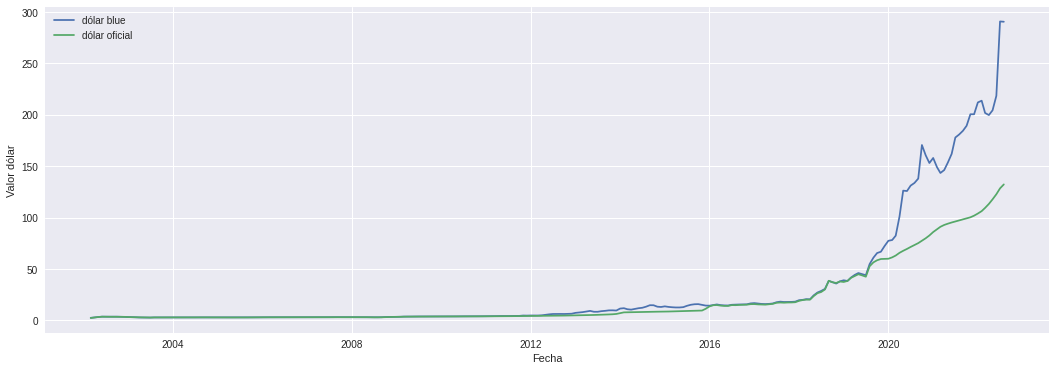

In [ ]:
from datetime import datetime

x = [datetime.strptime(str(i), "%Y-%m") for i in var_vs_sucesos['fecha']]
y1 = var_vs_sucesos['dolar']
y2 = var_vs_sucesos['dolar_of']

fig, ax = plt.subplots(figsize=(18, 6), sharex=True)

ax.plot(x, y1, label='dólar blue')
ax.plot(x, y2, label='dólar oficial')

plt.xlabel('Fecha')
plt.ylabel('Valor dólar')


plt.legend()
plt.show()

## Regresion lineal

### Pruebas de preparacion de distintos dataframes

In [ ]:
of_vs_blue_reg.head()

,date,dolar_of,dolar,dif_dolar,var_brecha,anio,mes
0,2002-03-04,2.01,2.12,0.11,0.00,2002,3
1,2002-03-05,1.99,2.12,0.13,0.02,2002,3
2,2002-03-06,2.05,2.14,0.09,-0.04,2002,3
3,2002-03-07,2.14,2.22,0.08,-0.01,2002,3
4,2002-03-08,2.20,2.27,0.07,-0.01,2002,3


In [ ]:
of_vs_blue_reg['anio'] = (of_vs_blue_reg['date'].dt.year).astype(int)
of_vs_blue_reg['mes'] = (of_vs_blue_reg['date'].dt.month).astype(int)
of_vs_blue_reg['dia'] = (of_vs_blue_reg['date'].dt.day).astype(int)
of_vs_blue_reg

,date,dolar_of,dolar,dif_dolar,var_brecha,anio,mes,dia
0,2002-03-04,2.01,2.12,0.11,0.00,2002,3,4
1,2002-03-05,1.99,2.12,0.13,0.02,2002,3,5
2,2002-03-06,2.05,2.14,0.09,-0.04,2002,3,6
3,2002-03-07,2.14,2.22,0.08,-0.01,2002,3,7
4,2002-03-08,2.20,2.27,0.07,-0.01,2002,3,8
...,...,...,...,...,...,...,...,...
5005,2022-07-29,131.23,296.00,164.77,-18.10,2022,7,29
5006,2022-08-01,131.94,282.00,150.06,-14.71,2022,8,1
5007,2022-08-02,132.18,291.00,158.82,8.76,2022,8,2
5008,2022-08-03,132.41,298.00,165.59,6.77,2022,8,3


In [ ]:
# Creo los dataframes con las fechas en enteros para las distintas regresiones
reg_of = of_vs_blue_reg[['dia', 'mes', 'anio', 'dolar_of']]
reg_blue = of_vs_blue_reg[['dia', 'mes', 'anio', 'dolar']]
reg_of.head()

,dia,mes,anio,dolar_of
0,4,3,2002,2.01
1,5,3,2002,1.99
2,6,3,2002,2.05
3,7,3,2002,2.14
4,8,3,2002,2.20


In [ ]:
# Limito la fecha para ver si mi modelo se esta sobreentrenando
reg_of = reg_of[reg_of['anio'] > 2018]
reg_blue = reg_blue[reg_blue['anio'] > 2017]

### Regresión en dólar oficial

In [ ]:
# Importo las librerias para la regresión lineal
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
# Modelo del dolar oficial
y = reg_of['dolar_of']
X = reg_of.drop('dolar_of', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=42)

model_of = LinearRegression()
model_of.fit(X_train, y_train)
model_of.score(X_test,y_test)

0.9874759302377377

In [ ]:
model_of.predict([[5,8,2023]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


array([145.5619552])

### Modelo de predicción del dolar blue

In [ ]:
# Modelo del dolar blue
y = reg_blue['dolar']
X = reg_blue.drop('dolar', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

model_blue = LinearRegression()
model_blue.fit(X_train, y_train)
model_blue.score(X_test,y_test)

0.9326615612757576

In [ ]:
model_blue.predict([[5,8,2023]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


array([283.44249361])

## Mejor momento para comprar dolar oficial y vender dolar blue

Este momento fue el momento con el la mayor diferencia entre estos valores.

In [ ]:
of_vs_blue.loc[of_vs_blue['dif_dolar'] == of_vs_blue['dif_dolar'].max()][['date', 'dolar_of', 'dolar', 'dif_dolar']]

,date,dolar_of,dolar,dif_dolar
235,2022-07-22,129.76,338.0,208.24
